In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Dataset

Mounted at /gdrive
/gdrive/My Drive/Dataset


In [3]:
# Hyperparameters
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 50
n_classes = 5

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train1",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5034 files belonging to 5 classes.


In [5]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "test1",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1162 files belonging to 5 classes.


In [6]:
class_names = train_ds.class_names

# Prefetch datasets for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
base_model = tf.keras.applications.EfficientNetB7(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze the base model

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [8]:
# Build the EfficientNetB7 model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
output_layer = layers.Dense(n_classes, activation="softmax")(x)

model = models.Model(inputs=base_model.input, outputs=output_layer)

In [9]:
# Compile the model
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])


In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 64)   │          1,728 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 64)   │            256 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 64)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 64)   │            576 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 64)   │            256 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 64)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 64)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 64)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 16)       │          1,040 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 64,110,492 (244.56 MB)

 Trainable params: 12,805 (50.02 KB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [11]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 2276s 4s/step - accuracy: 0.6788 - loss: 0.9183 - val_accuracy: 0.9329 - val_loss: 0.2873
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 47s 276ms/step - accuracy: 0.9143 - loss: 0.3064 - val_accuracy: 0.9561 - val_loss: 0.1818
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 44s 277ms/step - accuracy: 0.9435 - loss: 0.2161 - val_accuracy: 0.9699 - val_loss: 0.1329
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 82s 276ms/step - accuracy: 0.9553 - loss: 0.1725 - val_accuracy: 0.9742 - val_loss: 0.1129
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 43s 274ms/step - accuracy: 0.9610 - loss: 0.1465 - val_accuracy: 0.9776 - val_loss: 0.0930
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 82s 276ms/step - accuracy: 0.9684 - loss: 0.1299 - val_accuracy: 0.9828 - val_loss: 0.0814
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 82s 279ms/step - accuracy: 0.9669 - loss: 0.1190 - val_accuracy: 0.9880 - val_loss: 0.0681
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 44s 279ms/step - accuracy: 0.9707 - loss: 0.

In [12]:
# Evaluate the model on the test set
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 1.0000 - loss: 0.0075
Test Accuracy: 100.00%


In [13]:
# Plot training accuracy and loss
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]


Text(0.5, 1.0, 'Training and Validation Accuracy')

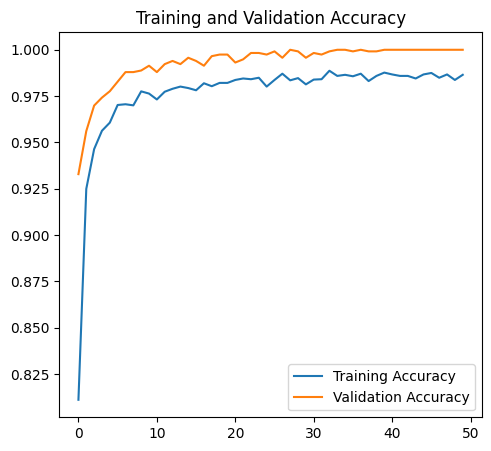

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")


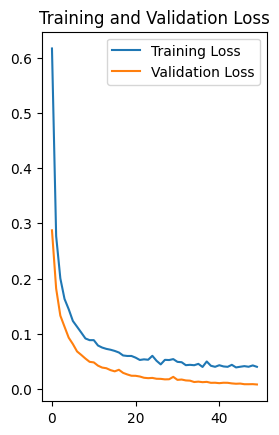

In [15]:
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
Predicted label: up curl (99.54%)


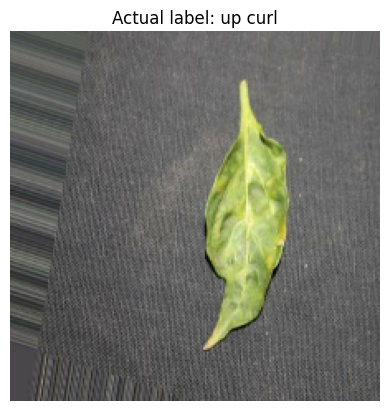

In [16]:
# Display first image prediction from test set
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    plt.imshow(first_image)
    plt.title(f"Actual label: {class_names[first_label]}")
    plt.axis("off")
     # Predict the batch
    batch_prediction = model.predict(images_batch)
    predicted_class_idx = np.argmax(batch_prediction[0])
    predicted_class_name = class_names[predicted_class_idx]
    confidence = batch_prediction[0][predicted_class_idx]

    print(f"Predicted label: {predicted_class_name} ({confidence * 100:.2f}%)")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8

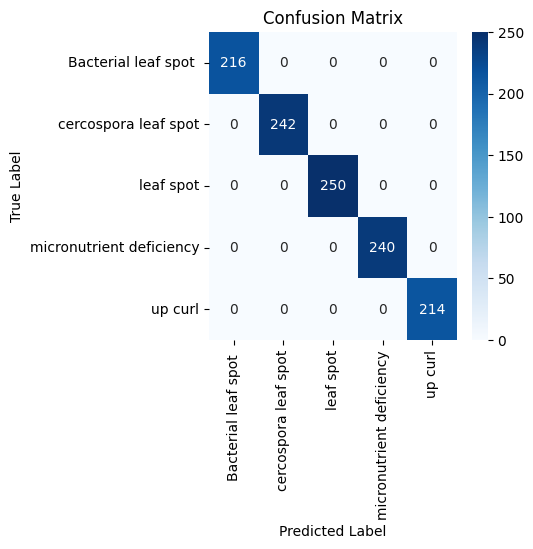

                          precision    recall  f1-score   support

    Bacterial leaf spot        1.00      1.00      1.00       216
    cercospora leaf spot       1.00      1.00      1.00       242
               leaf spot       1.00      1.00      1.00       250
micronutrient deficiency       1.00      1.00      1.00       240
                 up curl       1.00      1.00      1.00       214

                accuracy                           1.00      1162
               macro avg       1.00      1.00      1.00      1162
            weighted avg       1.00      1.00      1.00      1162



In [19]:
 #Confusion matrix and classification report
y_true = []
y_pred = []
for images_batch, labels_batch in test_ds:
    y_true.extend(labels_batch.numpy())
    predictions = model.predict(images_batch)
    y_pred.extend(np.argmax(predictions, axis=-1))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


In [18]:
model.save("chilli_efficientnet_b7.h5")